In [59]:
# additional functions to handle the data
from polepos_funcs import load_transmission_data_csv, plot_trcs, plot_search_results, delete_nan_cs_rows, search_peaks
import pandas as pd
import json

import numpy as np
from ATARI import PiTFAll as pf

In [60]:
%matplotlib widget

In [91]:
import os

test_data = os.path.realpath('../../Fitting/fitting_lite/syndat_data_SLBW.hdf5')

i = 2

# read pw and order 
test = pd.read_hdf(test_data, f'sample_{i}/exp_pw')
n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)
test['exp_cs'] = np.log(test['exp_trans']) / (-n)
test['theo_cs'] = np.log(test['theo_trans']) / (-n)
test.sort_values('E', inplace=True)
test.reset_index(drop=False,inplace=True)


test_par = pd.read_hdf(test_data, f'sample_{i}/theo_par')

# from matplotlib.pyplot import *
# # figure()
# # plot(test.E, test.exp_cs, '.')
# # plot(test.E, np.log(test['theo_trans']) / (-n))
test

,index,E,theo_trans,exp_trans,exp_cs,theo_cs
0,73,100.207897,0.784299,0.781564,3.669382,3.617376
1,72,100.444919,0.784309,0.779251,3.713517,3.617195
2,71,100.682783,0.784319,0.777222,3.752326,3.617008
3,70,100.921492,0.784329,0.793820,3.437737,3.616815
4,69,101.161052,0.784339,0.766289,3.963246,3.616615
...,...,...,...,...,...,...
69,4,118.769330,0.494184,0.483898,10.807259,10.494096
70,3,119.075217,0.562946,0.547425,8.970766,8.554513
71,2,119.382286,0.732783,0.717667,4.939253,4.628910
72,1,119.690546,0.758182,0.781785,3.665178,4.121599


In [62]:
# # input data - transmission dataframe - syndat output and calculating the cross section values

# tr_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_transmission_4980.csv'
# n = 0.067166 # atoms per barn or atoms/(1e-12*cm^2)

# transm_df = load_transmission_data_csv(tr_filename, n=n)

# transm_df

transm_df = test

In [63]:
# deleting all points with the negative transmission
transm_nonzero = delete_nan_cs_rows(transm_df)
transm_nonzero

Count in initial: 74 
Count in cleaned 74


,row_num,E,theo_trans,exp_trans,exp_cs,theo_cs
0,0,100.207897,0.784299,0.781564,3.669382,3.617376
1,1,100.444919,0.784309,0.779251,3.713517,3.617195
2,2,100.682783,0.784319,0.777222,3.752326,3.617008
3,3,100.921492,0.784329,0.793820,3.437737,3.616815
4,4,101.161052,0.784339,0.766289,3.963246,3.616615
...,...,...,...,...,...,...
69,69,118.769330,0.494184,0.483898,10.807259,10.494096
70,70,119.075217,0.562946,0.547425,8.970766,8.554513
71,71,119.382286,0.732783,0.717667,4.939253,4.628910
72,72,119.690546,0.758182,0.781785,3.665178,4.121599


In [64]:
# # loading ladder
# ladder_filename = 'test_data/_Emin_10_Emax_1000_2022.10.30_ladder.csv'

# ladder_df = pd.read_csv(ladder_filename, index_col=0)

# #modifying the ladder using json for correct lists in data lwave
# test = ladder_df.lwave.apply(json.loads)
# ladder_df['lwave'] = test

# ladder_df

In [65]:
ladder_df = test_par

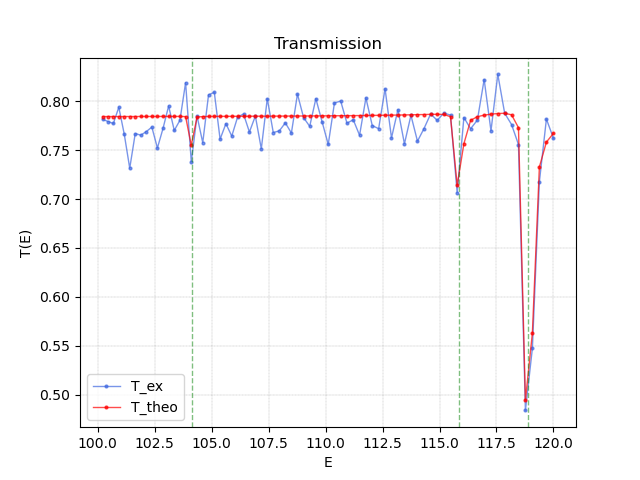

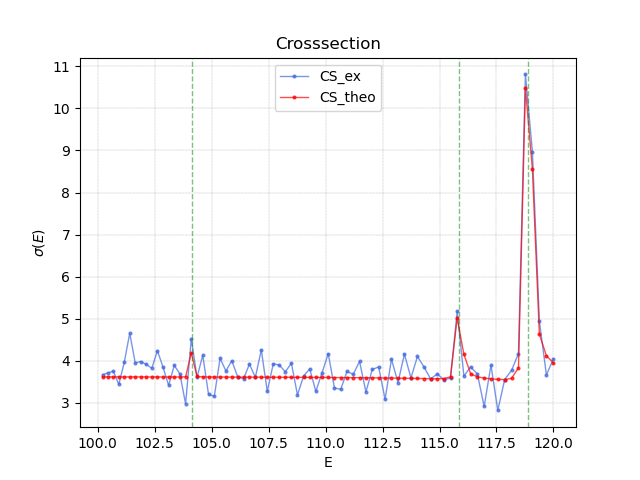

In [66]:
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy()],
    [transm_df['exp_trans'].to_numpy(), transm_df['theo_trans'].to_numpy()],
    'Transmission',
    ['T_ex', 'T_theo'],
    'E',
    'T(E)',
    ladder_df
)

# the same for cross-section values and adding the "clear values"
# plotting what we have
plot_trcs(
    [transm_df['E'].to_numpy(), transm_df['E'].to_numpy(), ],
    [transm_df['exp_cs'].to_numpy(), transm_df['theo_cs'].to_numpy()],
    'Crosssection',
    ['CS_ex', 'CS_theo', 'CS_ex_woNANS'],
    'E',
    '$\sigma(E)$',
    ladder_df
)

In [67]:
# using the find_all procedure to get all the peaks of cross-sections

# parameters of polepos
polepos_hps = {'search_params' : {'part_of_variance_filter': 0.2,
                                  'base_of_peak': 0.5, 
                                 'min_width': 0.01,
                                 'min_height': 0.01,
                                 'prominence': 0.01
                                 }, 

                 'reduce_params' : {'param_cutoff_by_name': 'peak_sq_divE',
                                    'cutoff_threshold': 0.03
                                    }
}

pulses_sel_df, pulses_all_df  = search_peaks(transm_nonzero,                    
                 search_params = polepos_hps['search_params'],           
                 reduce_params = polepos_hps['reduce_params']
)

Initial search gives: 26 peaks
Selected 19 peaks from 26


In [68]:
# actual number of resonances in a current ladder

print(f'We have in a actual ladder: {ladder_df.shape[0]}')

We have in a actual ladder: 3


In [89]:
# sorting result by weighted square
# pulses_sel_df.sort_values(by=['peak_sq_divE'], ascending=False)
pulses_sel_df.nlargest(6, 'peak_sq_divE')#.peak_E

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
25,25,69,118.769330,68,71,3,7.236125,118.464621,119.382286,0.917665,10.807026,7.141802,4,9.917234,7.714141,8.406267,1.0
22,22,59,115.774226,58,60,2,4.076454,115.480963,116.068608,0.587645,5.180083,2.207259,3,3.044050,2.737031,4.657627,1.0
1,1,5,101.401466,4,6,2,4.046813,101.161052,101.642737,0.481685,4.655866,1.218106,3,2.242663,2.130417,4.422838,1.0
5,5,16,104.103559,15,17,2,3.805479,103.853478,104.354544,0.501067,4.524885,1.438811,3,2.267268,2.060977,4.113180,1.0
3,3,10,102.616487,9,11,2,4.031753,102.371742,102.862110,0.490369,4.240135,0.416764,3,2.079229,2.013301,4.105688,1.0
10,10,28,107.176343,27,29,2,3.705238,106.915115,107.438529,0.523414,4.256910,1.103344,3,2.228128,2.085689,3.984777,1.0


In [70]:
# pulses_all_df.sort_values(by=['peak_height'], ascending=True)

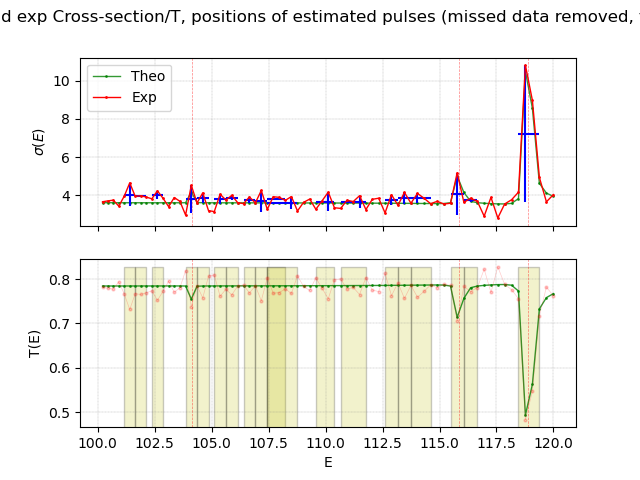

In [71]:
# plotting the results
plot_search_results(transm_df, ladder_df, pulses_sel_df)

In [72]:
pulses_sel_df[pulses_sel_df['peak_sq_divE']]

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
1,1,5,101.401466,4,6,2,4.046813,101.161052,101.642737,0.481685,4.655866,1.218106,3,2.242663,2.130417,4.422838,1.0
2,2,7,101.884871,6,8,2,3.966432,101.642737,102.127871,0.485134,3.982641,0.032417,3,1.932114,1.923806,3.965516,1.0
3,3,10,102.616487,9,11,2,4.031753,102.371742,102.862110,0.490369,4.240135,0.416764,3,2.079229,2.013301,4.105688,1.0
5,5,16,104.103559,15,17,2,3.805479,103.853478,104.354544,0.501067,4.524885,1.438811,3,2.267268,2.060977,4.113180,1.0
6,6,18,104.606439,17,19,2,3.868756,104.354544,104.859246,0.504702,4.133259,0.529006,3,2.086063,1.963225,3.889871,1.0
7,7,21,105.367618,20,22,2,3.815468,105.112971,105.623192,0.510221,4.062240,0.493543,3,2.072639,1.969493,3.860082,1.0
8,8,23,105.879696,22,24,2,3.878569,105.623192,106.137136,0.513944,4.001458,0.245778,3,2.056527,2.003212,3.897722,1.0
9,9,26,106.654841,25,27,2,3.763886,106.395516,106.915115,0.519599,3.920480,0.313187,3,2.037076,1.979505,3.809682,1.0
10,10,28,107.176343,27,29,2,3.705238,106.915115,107.438529,0.523414,4.256910,1.103344,3,2.228128,2.085689,3.984777,1.0
11,11,30,107.701679,29,32,3,3.835199,107.438529,108.230887,0.792358,3.930340,0.190282,4,3.114236,3.012209,3.801576,1.0


In [73]:
pulses_all_df

,idx_global_num,x,peak_E,peak_left_border_indx,peak_right_border_indx,peak_width_samples,peak_relative_prom_width_height,peak_left_border_E,peak_right_border_E,peak_width_E,peak_height,peak_prominence,peak_numpoints,peak_simple_sq,peak_sq,peak_sq_divE,selected
0,0,2,100.682783,0,3,3,3.710850,100.207897,100.921492,0.713595,3.752316,0.082933,4,2.677636,2.628166,3.682992,0.0
1,1,5,101.401466,4,6,2,4.046813,101.161052,101.642737,0.481685,4.655866,1.218106,3,2.242663,2.130417,4.422838,1.0
2,2,7,101.884871,6,8,2,3.966432,101.642737,102.127871,0.485134,3.982641,0.032417,3,1.932114,1.923806,3.965516,1.0
3,3,10,102.616487,9,11,2,4.031753,102.371742,102.862110,0.490369,4.240135,0.416764,3,2.079229,2.013301,4.105688,1.0
4,4,13,103.356011,12,15,3,3.651438,103.108617,103.853478,0.744861,3.889037,0.475198,4,2.896790,2.698935,3.623410,0.0
5,5,16,104.103559,15,17,2,3.805479,103.853478,104.354544,0.501067,4.524885,1.438811,3,2.267268,2.060977,4.113180,1.0
6,6,18,104.606439,17,19,2,3.868756,104.354544,104.859246,0.504702,4.133259,0.529006,3,2.086063,1.963225,3.889871,1.0
7,7,21,105.367618,20,22,2,3.815468,105.112971,105.623192,0.510221,4.062240,0.493543,3,2.072639,1.969493,3.860082,1.0
8,8,23,105.879696,22,24,2,3.878569,105.623192,106.137136,0.513944,4.001458,0.245778,3,2.056527,2.003212,3.897722,1.0
9,9,26,106.654841,25,27,2,3.763886,106.395516,106.915115,0.519599,3.920480,0.313187,3,2.037076,1.979505,3.809682,1.0
